In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
!pip install GPUtil
import gc
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import random
import timm

In [2]:
import albumentations as A
# import cv2
from albumentations.pytorch import ToTensorV2
import numpy as np
import copy

In [3]:
import wandb

In [3]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

In [5]:
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [6]:
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


In [7]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

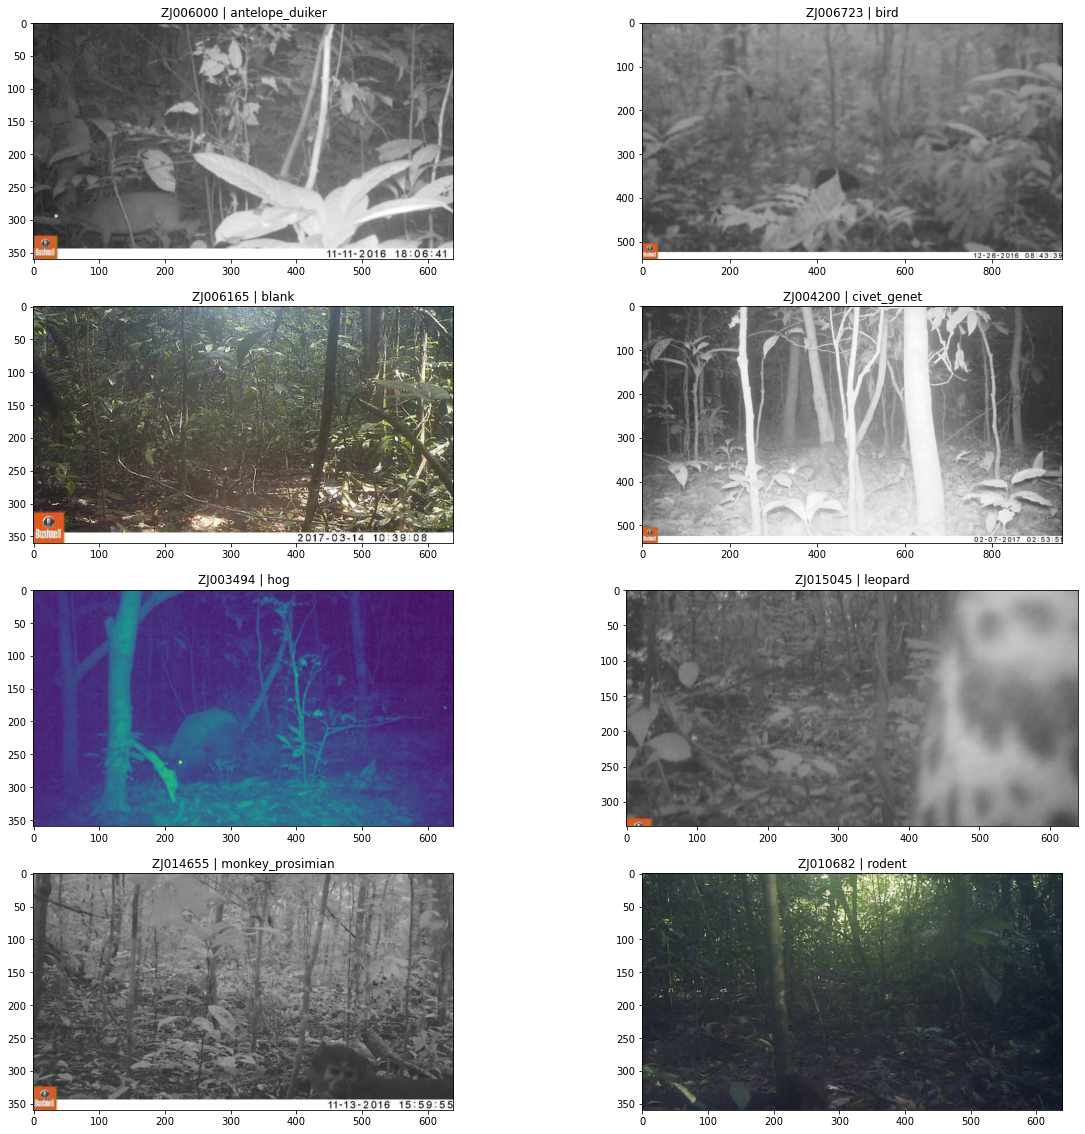

In [5]:
import matplotlib.image as mpimg

random_state = 42

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

In [11]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
frac = 1

y = train_labels.sample(frac=frac, random_state=4)
x = train_features.loc[y.index].filepath.to_frame()
# print(x)
# print(y)
# note that we are casting the species labels to an indicator/dummy matrix

x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.2
)

In [ ]:
import time

start = time.time()



from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
list_of_sites = []
for row in train_features.itertuples(index=False):
    for k,v in enumerate(row):
        konec = v[-3:]
        if konec == "jpg":
            pass
        else:
            list_of_sites.append(konec)
# print(list_of_sites)
list_of_ids = []
for row in train_features.itertuples(index=False):
    for k,v in enumerate(row):
        image_ids = v[15:23]
        if image_ids == "":
            pass
        else:
            list_of_ids.append(image_ids)
# print(list_of_ids)
list_of_class_numbers = []

counterr = 0
for row in train_labels.itertuples(index=False):
    for a,b in enumerate(row):
        if b == 1.0:
            list_of_class_numbers.append(counterr)
        counterr = counterr + 1
    counterr = 0

x = list_of_ids
y = list_of_class_numbers
groups = list_of_sites
train_fold = [[],[],[],[],[]]
test_fold = [[],[],[],[],[]]
counter = 0;
for train, test in skf.split(x, y):
    train_fold[counter] = train
    test_fold[counter] = test
    counter = counter+1

x_train2 =[]
y_train2 =[]
x_eval2 = []
y_eval2 = []
for j in range(5):
    d = train_features
    d1 = train_labels
    y0 = train_features
    y1 = train_labels

    d = d.drop(['site'], axis=1)
    y0 = y0.drop(['site'], axis=1)
    index = d.index

    list_of_ids_infold = []
    for i in train_fold[j]:
        list_of_ids_infold.append(list_of_ids[i])

    rozdil = []
    rozdil = sorted(list(set(index) - set(list_of_ids_infold)))

    for i in rozdil:    
        d = d.drop(i)
        d1 = d1.drop(i)
    for i in list_of_ids_infold:
        y0 = y0.drop(i)
        y1 = y1.drop(i)
    x_train2.append(d)
    y_train2.append(d1)
    x_eval2.append(y0)
    y_eval2.append(y1)
end = time.time()

In [17]:
split_pcts = pd.DataFrame(
    {
        "train": y_train2[0].idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval2[0].idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)
# wandb.log({"table - Stratified" : (split_pcts.fillna(0) * 100).astype(int)})

Species percentages by split


,train,eval
monkey_prosimian,15,15
antelope_duiker,15,15
civet_genet,14,14
leopard,13,13
blank,13,13
rodent,12,12
bird,9,9
hog,5,5


In [6]:
import time

start = time.time()



from sklearn.model_selection import StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5)
list_of_sites = []
for row in train_features.itertuples(index=False):
    for k,v in enumerate(row):
        konec = v[-3:]
        if konec == "jpg":
            pass
        else:
            list_of_sites.append(konec)
# print(list_of_sites)
list_of_ids = []
for row in train_features.itertuples(index=False):
    for k,v in enumerate(row):
        image_ids = v[15:23]
        if image_ids == "":
            pass
        else:
            list_of_ids.append(image_ids)
# print(list_of_ids)
list_of_class_numbers = []

counterr = 0
for row in train_labels.itertuples(index=False):
    for a,b in enumerate(row):
        if b == 1.0:
            list_of_class_numbers.append(counterr)
        counterr = counterr + 1
    counterr = 0

x = list_of_ids
y = list_of_class_numbers
groups = list_of_sites
train_fold = [[],[],[],[],[]]
test_fold = [[],[],[],[],[]]
counter = 0;
for train, test in sgkf.split(x, y, groups=groups):
    train_fold[counter] = train
    test_fold[counter] = test
    counter = counter+1

x_train1 =[]
y_train1 =[]
x_eval1 = []
y_eval1 = []
for j in range(5):
    d = train_features
    d1 = train_labels
    y0 = train_features
    y1 = train_labels

    d = d.drop(['site'], axis=1)
    y0 = y0.drop(['site'], axis=1)
    index = d.index

    list_of_ids_infold = []
    for i in train_fold[j]:
        list_of_ids_infold.append(list_of_ids[i])

    rozdil = []
    rozdil = sorted(list(set(index) - set(list_of_ids_infold)))

    for i in rozdil:    
        d = d.drop(i)
        d1 = d1.drop(i)
    for i in list_of_ids_infold:
        y0 = y0.drop(i)
        y1 = y1.drop(i)
    x_train1.append(d)
    y_train1.append(d1)
    x_eval1.append(y0)
    y_eval1.append(y1)

end = time.time()
print(end - start)
print(d)
print(d1)
print(len(train_fold[0]),len(train_fold[1]),len(train_fold[2]),len(train_fold[3]),len(train_fold[4]))
print(y0)
print(y1)
print(len(test_fold[0]))

309.00996446609497
                             filepath
id                                   
ZJ000000  train_features/ZJ000000.jpg
ZJ000001  train_features/ZJ000001.jpg
ZJ000002  train_features/ZJ000002.jpg
ZJ000004  train_features/ZJ000004.jpg
ZJ000005  train_features/ZJ000005.jpg
...                               ...
ZJ016482  train_features/ZJ016482.jpg
ZJ016483  train_features/ZJ016483.jpg
ZJ016484  train_features/ZJ016484.jpg
ZJ016486  train_features/ZJ016486.jpg
ZJ016487  train_features/ZJ016487.jpg

[13349 rows x 1 columns]
          antelope_duiker  bird  blank  civet_genet  hog  leopard  \
id                                                                  
ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   
ZJ000005              0.0   0.0    0.0         

In [13]:
split_pcts = pd.DataFrame(
    {
        "train": y_train1[0].idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval1[0].idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)
# wandb.log({"table - Stratified" : (split_pcts.fillna(0) * 100).astype(int)})

Species percentages by split


,train,eval
antelope_duiker,14,15
bird,9,10
blank,13,13
civet_genet,15,11
hog,5,6
leopard,13,14
monkey_prosimian,15,15
rodent,12,12


In [7]:
import torch
torch.cuda.empty_cache()
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None,device='cuda',transform=None):
        self.data = x_df
        self.label = y_df
        self.transform = transform
        

    def __getitem__(self, index,device='cuda'):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        # Convert PIL image to numpy array
        image_np = np.array(image)
        # Apply transformations
        image = self.transform(image=image_np)["image"]
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

## augumentation


In [9]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussianBlur(blur_limit = (3,7) ,p=0.2),
    A.OneOf([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,p=1),
        ], p=0.5),
    A.OneOf([
            A.HueSaturationValue(p=0.6,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
            A.RGBShift(p=0.4),
        ], p=0.2),
    A.Equalize (mode='pil', by_channels=True, mask=None, mask_params=(), always_apply=False, p=0.05),
    A.Resize(256, 256),
    A.CenterCrop(224,224), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
])


In [8]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussianBlur(blur_limit = (3,7) ,p=0.2),
    A.OneOf([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,p=1),
        ], p=0.5),
    A.OneOf([
            A.HueSaturationValue(p=0.6,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
            A.RGBShift(p=0.4),
        ], p=0.2),
    A.Equalize (mode='pil', by_channels=True, mask=None, mask_params=(), always_apply=False, p=0.05),
    A.Resize(256, 256),
    A.CenterCrop(224,224), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
])

In [35]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussianBlur(blur_limit = (3,7) ,p=0.2),
    A.OneOf([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,p=1),
        ], p=0.5),
    A.OneOf([
            A.HueSaturationValue(p=0.6,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
            A.RGBShift(p=0.4),
        ], p=0.2),
    A.Equalize (mode='pil', by_channels=True, mask=None, mask_params=(), always_apply=False, p=0.05),
    A.Resize(300, 300),
    A.CenterCrop(288,288), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
])

In [13]:
train_transform = A.Compose([
    A.Resize(224, 224), 
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
])

In [9]:
val_transform = A.Compose([
    A.Resize(224, 224), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
])

In [28]:
val_transform = A.Compose([
    A.Resize(288, 288), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
])

In [11]:
# val_transform = A.Compose(
#             [   
#                 transforms.Resize((224, 224)),
#                 transforms.ToTensor(),
#                 transforms.Normalize(
#                     mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
#                 ),
#             ]
#         )

In [10]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train1[0], y_train1[0],transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=8,shuffle=True)

In [ ]:
# avail_pretrained_models = timm.list_models(pretrained=True)
# len(avail_pretrained_models), avail_pretrained_models

In [ ]:
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=8)
num_in_features = model.get_classifier().in_features;
model.default_cfg #288

In [73]:
model = timm.create_model('vit_relpos_base_patch16_224', pretrained=True, num_classes=8)
num_in_features = model.get_classifier().in_features;
model.default_cfg #224

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tpu-weights/vit_relpos_base_patch16_224-sw-49049aed.pth" to C:\Users\Destr/.cache\torch\hub\checkpoints\vit_relpos_base_patch16_224-sw-49049aed.pth


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tpu-weights/vit_relpos_base_patch16_224-sw-49049aed.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': None,
 'crop_pct': 0.9,
 'interpolation': 'bicubic',
 'fixed_input_size': True,
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'first_conv': 'patch_embed.proj',
 'classifier': 'head',
 'architecture': 'vit_relpos_base_patch16_224'}

In [21]:
model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes=8)
num_in_features = model.get_classifier().in_features;
model.default_cfg # 224

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth" to C:\Users\Destr/.cache\torch\hub\checkpoints\resnext50_32x4d_a1h-0146ab0a.pth


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.95,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnext50_32x4d'}

In [22]:
model = timm.create_model('seresnext50_32x4d', pretrained=True, num_classes=8)
num_in_features = model.get_classifier().in_features;
model.default_cfg # 224

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to C:\Users\Destr/.cache\torch\hub\checkpoints\seresnext50_32x4d_racm-a304a460.pth


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'seresnext50_32x4d'}

In [23]:
model = timm.create_model('vit_relpos_medium_patch16_224', pretrained=True, num_classes=8)
num_in_features = model.get_classifier().in_features;
model.default_cfg # 0.5 std/mean
# 224

C:\Users\Destr\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tpu-weights/vit_relpos_medium_patch16_224-sw-11c174af.pth" to C:\Users\Destr/.cache\torch\hub\checkpoints\vit_relpos_medium_patch16_224-sw-11c174af.pth


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tpu-weights/vit_relpos_medium_patch16_224-sw-11c174af.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': None,
 'crop_pct': 0.9,
 'interpolation': 'bicubic',
 'fixed_input_size': True,
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'first_conv': 'patch_embed.proj',
 'classifier': 'head',
 'architecture': 'vit_relpos_medium_patch16_224'}

In [11]:
from torch import nn
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = timm.create_model('vit_relpos_medium_patch16_224', pretrained=True, num_classes=8)
num_in_features = model.get_classifier().in_features;
model.fc = nn.Sequential(
    nn.Linear(
        num_in_features, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)
net = model
net = net.cuda()
next(net.parameters()).is_cuda #returns a bool value, True - your model is truly on GPU, False - it is not

C:\Users\Destr\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


True

In [ ]:
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=5)
num_in_features = model.get_classifier().in_features;
model.fc = nn.Sequential(
    nn.Linear(num_in_features, 100),  # dense layer takes a 1280-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 5
    ),  # final dense layer outputs 5-dim corresponding to our target classes
)

In [34]:
from torch import nn
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=8)
num_in_features = model.get_classifier().in_features;
model.fc = nn.Sequential(
    nn.Linear(
        num_in_features, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)
net = model
net = net.cuda()
next(net.parameters()).is_cuda #returns a bool value, True - your model is truly on GPU, False - it is not

True

In [12]:
from torch import nn
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    #nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    #nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    #nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        2048, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)
net = model
net = net.cuda()
next(net.parameters()).is_cuda #returns a bool value, True - your model is truly on GPU, False - it is not

C:\Users\Destr\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Destr\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True

In [21]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FocalLoss(nn.CrossEntropyLoss):
#     ''' Focal loss for classification tasks on imbalanced datasets '''

#     def __init__(self, gamma, alpha=None, ignore_index=-100, reduction='none'):
#         super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
#         self.reduction = reduction
#         self.gamma = gamma

#     def forward(self, input_, target):
#         cross_entropy = super().forward(input_, target)
#         # Temporarily mask out ignore index to '0' for valid gather-indices input.
#         # This won't contribute final loss as the cross_entropy contribution
#         # for these would be zero.
#         target = target * (target != self.ignore_index).long()
#         input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
#         loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy  
#         if self.reduction == 'mean':
#             return torch.mean(loss)
#         elif self.reduction == 'sum':
#             return torch.sum(loss) 
#         else: loss

In [11]:
# import torch.nn as nn
# import torch.nn.functional as F
# ALPHA = 0.25
# GAMMA = 2

# class FocalLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(FocalLoss, self).__init__()

#     def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #first compute binary cross-entropy 
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         BCE_EXP = torch.exp(-BCE)
#         focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
#         return focal_loss

In [23]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable

# class FocalLoss(nn.Module):
#     r"""
#         This criterion is a implemenation of Focal Loss, which is proposed in 
#         Focal Loss for Dense Object Detection.

#             Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])

#         The losses are averaged across observations for each minibatch.

#         Args:
#             alpha(1D Tensor, Variable) : the scalar factor for this criterion
#             gamma(float, double) : gamma > 0; reduces the relative loss for well-classiﬁed examples (p > .5), 
#                                    putting more focus on hard, misclassiﬁed examples
#             size_average(bool): By default, the losses are averaged over observations for each minibatch.
#                                 However, if the field size_average is set to False, the losses are
#                                 instead summed for each minibatch.


#     """
#     def __init__(self, class_num, alpha=None, gamma=2, size_average=True):
#         super(FocalLoss, self).__init__()
#         if alpha is None:
#             self.alpha = Variable(torch.ones(class_num, 1))
#         else:
#             if isinstance(alpha, Variable):
#                 self.alpha = alpha
#             else:
#                 self.alpha = Variable(alpha)
#         self.gamma = gamma
#         self.class_num = class_num
#         self.size_average = size_average

#     def forward(self, inputs, targets):
#         N = inputs.size(0)
#         C = inputs.size(1)
#         P = F.softmax(inputs)

#         class_mask = inputs.data.new(N, C).fill_(0)
#         class_mask = Variable(class_mask)
#         ids = targets.view(-1, 1)
#         class_mask.scatter_(1, ids.data, 1.)
#         print(class_mask)


#         if inputs.is_cuda and not self.alpha.is_cuda:
#             self.alpha = self.alpha.cuda()
#         alpha = self.alpha[ids.data.view(-1)]

#         probs = (P*class_mask).sum(1).view(-1,1)

#         log_p = probs.log()
#         print('probs size= {}'.format(probs.size()))
#         print(probs)

#         batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p 
#         print('-----bacth_loss------')
#         print(batch_loss)


#         if self.size_average:
#             loss = batch_loss.mean()
#         else:
#             loss = batch_loss.sum()
#         return loss

In [17]:
# from typing import Optional, Sequence

# import torch
# from torch import Tensor
# from torch import nn
# from torch.nn import functional as F


# class FocalLoss(nn.Module):
#     """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.
#     It is essentially an enhancement to cross entropy loss and is
#     useful for classification tasks when there is a large class imbalance.
#     x is expected to contain raw, unnormalized scores for each class.
#     y is expected to contain class labels.
#     Shape:
#         - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
#         - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
#     """

#     def __init__(self,
#                  alpha: Optional[Tensor] = None,
#                  gamma: float = 0.,
#                  reduction: str = 'mean',
#                  ignore_index: int = -100):
#         """Constructor.
#         Args:
#             alpha (Tensor, optional): Weights for each class. Defaults to None.
#             gamma (float, optional): A constant, as described in the paper.
#                 Defaults to 0.
#             reduction (str, optional): 'mean', 'sum' or 'none'.
#                 Defaults to 'mean'.
#             ignore_index (int, optional): class label to ignore.
#                 Defaults to -100.
#         """
#         if reduction not in ('mean', 'sum', 'none'):
#             raise ValueError(
#                 'Reduction must be one of: "mean", "sum", "none".')

#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.ignore_index = ignore_index
#         self.reduction = reduction

#         self.nll_loss = nn.NLLLoss(
#             weight=alpha, reduction='none', ignore_index=ignore_index)

#     def __repr__(self):
#         arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
#         arg_vals = [self.__dict__[k] for k in arg_keys]
#         arg_strs = [f'{k}={v!r}' for k, v in zip(arg_keys, arg_vals)]
#         arg_str = ', '.join(arg_strs)
#         return f'{type(self).__name__}({arg_str})'

#     def forward(self, x: Tensor, y: Tensor) -> Tensor:
#         if x.ndim > 2:
#             # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
#             c = x.shape[1]
#             x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
#             # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
#             y = y.view(-1)

#         unignored_mask = y != self.ignore_index
#         y = y[unignored_mask]
#         if len(y) == 0:
#             return torch.tensor(0.)
#         x = x[unignored_mask]

#         # compute weighted cross entropy term: -alpha * log(pt)
#         # (alpha is already part of self.nll_loss)
#         log_p = F.log_softmax(x, dim=-1)
#         ce = self.nll_loss(log_p, y)

#         # get true class column from each row
#         all_rows = torch.arange(len(x))
#         log_pt = log_p[all_rows, y]

#         # compute focal term: (1 - pt)^gamma
#         pt = log_pt.exp()
#         focal_term = (1 - pt)**self.gamma

#         # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
#         loss = focal_term * ce

#         if self.reduction == 'mean':
#             loss = loss.mean()
#         elif self.reduction == 'sum':
#             loss = loss.sum()

#         return loss


# def focal_loss(alpha: Optional[Sequence] = None,
#                gamma: float = 0.,
#                reduction: str = 'mean',
#                ignore_index: int = -100,
#                device='cpu',
#                dtype=torch.float32) -> FocalLoss:
#     """Factory function for FocalLoss.
#     Args:
#         alpha (Sequence, optional): Weights for each class. Will be converted
#             to a Tensor if not None. Defaults to None.
#         gamma (float, optional): A constant, as described in the paper.
#             Defaults to 0.
#         reduction (str, optional): 'mean', 'sum' or 'none'.
#             Defaults to 'mean'.
#         ignore_index (int, optional): class label to ignore.
#             Defaults to -100.
#         device (str, optional): Device to move alpha to. Defaults to 'cpu'.
#         dtype (torch.dtype, optional): dtype to cast alpha to.
#             Defaults to torch.float32.
#     Returns:
#         A FocalLoss object
#     """
#     if alpha is not None:
#         if not isinstance(alpha, Tensor):
#             alpha = torch.tensor(alpha)
#         alpha = alpha.to(device=device, dtype=dtype)

#     fl = FocalLoss(
#         alpha=alpha,
#         gamma=gamma,
#         reduction=reduction,
#         ignore_index=ignore_index)
#     return fl

In [44]:
# Class_numbers = train_labels.sum().sort_values(ascending=False)
# Class_number_of_images = sum(Class_numbers)
# Class_weight = []
# for i in range(len(Class_numbers)):
#     Class_weight.append(1 - (Class_numbers[i]/Class_number_of_images))
# T_Class_weight = torch.FloatTensor(Class_weight)
# print(T_Class_weight)
# from torch.nn import functional as F
# class FocalLoss(nn.Module):
#     '''
#     Multi-class Focal Loss
#     '''
#     def __init__(self, gamma=2, weight=T_Class_weight.to(device)):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.weight = weight

#     def forward(self, input, target):
#         """
#         input: [N, C], float32
#         target: [N, ], int64
#         """
#         logpt = F.log_softmax(input, dim=1)
#         print(f'logpt_softmax: {logpt}')
#         pt = torch.exp(logpt)
#         print(f'pt exp: {pt}')
#         logpt = (1-pt)**self.gamma * logpt
#         print(f'logpt_vypocet: {logpt}')
#         #print(target)
#         target = torch.argmax(target, dim=1)
#         print(f'target: {target}')
#         loss = F.nll_loss(logpt, target, self.weight)
#         return loss

tensor([0.8489, 0.8500, 0.8530, 0.8633, 0.8658, 0.8779, 0.9005, 0.9407])


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #label_smoothing=0.2
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [45]:
import torch.optim as optim

criterion = FocalLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
eval_dataset = ImagesDataset(x_eval1[0], y_eval1[0],transform=val_transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)
eval_true = y_eval1[0].idxmax(axis=1)
from sklearn.metrics import log_loss
display(eval_true)

id
ZJ000001    monkey_prosimian
ZJ000015               blank
ZJ000023             leopard
ZJ000035              rodent
ZJ000037     antelope_duiker
                  ...       
ZJ016471                bird
ZJ016475             leopard
ZJ016476              rodent
ZJ016478              rodent
ZJ016487         civet_genet
Length: 3183, dtype: object

In [14]:
def Cutout(num_images,length,batch,holes):
    #num_images = 2 # number of images
    #length = 40 # length(int) in pixels of each square
    batch_size = batch["label"].size(0)
    if batch_size < num_images:
        print("end")
        return(batch)
    num_holes = holes
    re_mask = []
    masks = []
    ran = random.sample(range(batch_size), num_images)
    h = 224 #height of image
    w = 224 #width of image
    mask = np.ones((h, w), np.float32)
    for n in range(num_images):
        for i in range(num_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - length // 2, 0, h)
            y2 = np.clip(y + length // 2, 0, h)
            x1 = np.clip(x - length // 2, 0, w)
            x2 = np.clip(x + length // 2, 0, w)
            mask[y1: y2, x1: x2] = 0.
        masks.append(mask)
        mask = np.ones((h, w), np.float32)
        
        
    for i in range(num_images):
        mask = torch.from_numpy(masks[i])
        mask = mask.expand_as(batch["image"][ran[i]])
        batch["image"][ran[i]] = batch["image"][ran[i]] * mask
    return(batch)

In [15]:
def Mixup(num_pairs,batch): # returns same size batch and float labels
    #num_pairs = 2 # number of pairs to change
    batch_size = batch["label"].size(0)
    if batch_size < num_pairs*2:
        print("end")
        return(batch)
    label_ratio = []
    ran = random.sample(range(batch_size), num_pairs*2)
    h = 224 #height of image
    w = 224 #width of image
    # check mixup paper na hodnou alpha a beta -> hodně malou?
    for i in range(num_pairs):
        img = batch["image"][ran[2*i]]
        img2 = batch["image"][ran[(2*i)+1]]
        r = np.random.beta(4.0, 4.0)  # mixup ratio, alpha=beta=32.0 # vyšší hodnota bety znamená blíže 50/50 promíchání
        im = img * r + img2 * (1 - r)
        label_0 = batch["label"][ran[(2*i)]] * r + batch["label"][ran[(2*i)+1]] * (1 - r)
        r = np.random.beta(4.0, 4.0)  # mixup ratio, alpha=beta=32.0 # vyšší hodnota bety znamená blíže 50/50 promíchání
        im2 = img2 * r + img * (1 - r)
        label_1 = batch["label"][ran[(2*i)+1]] * r + batch["label"][ran[(2*i)]] * (1 - r)
        batch["image"][ran[(2*i)]] = im
        img2 = batch["image"][ran[(2*i)+1]] = im2
        batch["label"][ran[(2*i)]] = label_0
        batch["label"][ran[(2*i)+1]] = label_1
    return(batch)

In [16]:
def Mixcut(num_pairs,length,batch):
    #num_pairs = 2 # Number of pairs from batch
    #length = 100 # length(int) in pixels
    batch_size = batch["label"].size(0)
    if batch_size < num_pairs*2:
        print("end")
        return(batch)
    label_ratio = []
    ran = random.sample(range(batch_size), num_pairs*2)
    
    changed_labels = []
    h = 224 #height of image
    w = 224 #width of image
    img_area = h*w
    mask = np.ones((h, w), np.float32)
    for n in range(num_pairs):
        y = np.random.randint(h)
        x = np.random.randint(w)
        
        y1 = np.clip(y - length // 2, 0, h)
        y2 = np.clip(y + length // 2, 0, h)
        x1 = np.clip(x - length // 2, 0, w)
        x2 = np.clip(x + length // 2, 0, w)
        
        y0 = random.randrange(-y1,h-y2)
        x0 = random.randrange(-x1,w-x2)
        y3 = random.randrange(-y1,h-y2)
        x3 = random.randrange(-x1,w-x2)
        mask_height = y2-y1
        mask_width = x2-x1
        area = mask_height * mask_width
        img_left = img_area - area
        ratio = img_left / img_area
        
        img = torch.clone(batch["image"][ran[(2*n)]])
        imga = torch.clone(batch["image"][ran[(2*n)+1]])
        batch["image"][ran[(2*n)]][:,y1: y2,x1: x2] = imga[:,y1+y0: y2+y0,x1+x0: x2+x0]
        batch["image"][ran[(2*n)+1]][:,y1: y2,x1: x2] = img[:,y1+y3: y2+y3,x1+x3: x2+x3]
        label_0 = batch["label"][ran[(2*n)]] * ratio + batch["label"][ran[(2*n)+1]] * (1 - ratio)
        label_1 = batch["label"][ran[(2*n)+1]] * ratio + batch["label"][ran[(2*n)]] * (1 - ratio)
        batch["label"][ran[(2*n)]] = label_0
        batch["label"][ran[(2*n)+1]] = label_1
    return(batch)

In [ ]:
# config = wandb.config
# config.learning_rate = 0.001
# config.momentum = 0.9
print_frequency = 100;
running_loss = 0.0
totalTrainAccuracy = 0
num_epochs = 1
min_val_loss = np.inf
max_acc = np.NINF
tracking_loss = {}
alpha = 0.25 # pridat
gamma = 2 #pridat

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")
    
    totalTrainAccuracy = 0
    trainAccuracy = 0
    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        
        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
#         print(f'[{batch["image"]}]')
#         print(f'[{batch["label"]}]')

        #batch = Mixup(2,batch)
        #batch = Mixup(2,batch)
        #batch = Mixcut(2,40,batch)
        #batch = Cutout(4,40,batch,2)
        outputs = model(batch["image"].to(device))
        # 3) compute the loss
        #print(f' outputs :[{outputs.type(torch.float64)}]')
        #print(f' batch label:[{batch["label"].to(device)}]')
        #print(f' batch label:[{batch["label"].to(device).type(torch.int64)}]')
        
        #loss = criterion(outputs, batch["label"].to(device).type(torch.int64)) # to.(device)
        
        cel = criterion(outputs, batch["label"].to(device))
        pt = torch.exp(-cel)
        focal_loss = (alpha * (1-pt)**gamma * cel) # mean over the batch
        loss = focal_loss

        #print(f'{loss}')
        # let's keep track of the loss by epoch and batch
        #tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        trainAccuracy = (predicted == torch.max(batch["label"].to(device),1)[1]).float().sum().item()
        trainAccuracy = 100 * trainAccuracy / batch["label"].size(0)
        totalTrainAccuracy += trainAccuracy
        
        #print(f'predicted: {predicted},image label: {batch["label"]} novy tensor:{torch.max(batch["label"].to(device),1)[1]}')        
        #print(f'[{epoch + 1}, {batch_n + 1:5d}] labelsize: {batch["label"].size(0)} trainacc: {trainAccuracy}')
        #print(f'[{epoch + 1}, {batch_n + 1:5d}] trainAccu: {trainAccuracy}')
        
        
        running_loss += loss.item()
        if batch_n % print_frequency == (print_frequency - 1): 
#           wandb.log({'loss': (running_loss / print_frequency)})
#           wandb.log({'epoch': epoch})
#           wandb.log({'Train_accuracy': totalTrainAccuracy / print_frequency})
          print(f'[{epoch}, {batch_n + 1:5d}] loss: {running_loss / print_frequency:.3f}')
          print(f'[{epoch}, {batch_n + 1:5d}] AvgtrainAccu: {totalTrainAccuracy / print_frequency:.3f}')
          running_loss = 0.0
          totalTrainAccuracy = 0
       # gc.collect()
       # torch.cuda.empty_cache()
        
    
        
        
        
    preds_collector = []
    valid_loss = 0.0
    # put the model in eval mode so we don't update any parameters
    model.eval()
    # we aren't updating our weights so no need to calculate gradients
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
            # 1) run the forward step
            logits = model.forward(batch["image"].to(device))
            # 2) apply softmax so that model outputs are in range [0,1]
            preds = nn.functional.softmax(logits, dim=1)
            # 3) store this batch's predictions in df
            val_loss = criterion(logits, batch["label"].to(device))
            pt = torch.exp(-val_loss)
            focal_loss = (alpha * (1-pt)**gamma * val_loss) # mean over the batch
            val_loss = focal_loss
            valid_loss += val_loss.item()
            # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
            preds_df = pd.DataFrame(
                preds.cpu().detach().numpy(),
                index=batch["image_id"],
                columns=species_labels,
            )
            preds_collector.append(preds_df)

    eval_preds_df = pd.concat(preds_collector)
    eval_predictions = eval_preds_df.idxmax(axis=1)
    
    correct = (eval_predictions == eval_true).sum()
    accuracy = correct / len(eval_predictions)
    validation_loss = valid_loss / len(eval_dataloader)
    competition_loss = log_loss(eval_true,eval_preds_df)
    model.train()
#     wandb.log({'Validation_Accuracy': accuracy})
#     wandb.log({'Validation_Loss': competition_loss})
#    if min_val_loss > competition_loss:
#        min_val_loss = competition_loss
#        best_model_loss = copy.deepcopy(model)
#    if max_acc < accuracy:
#        max_acc = accuracy
#        best_model_acc = copy.deepcopy(model)
#    if min_validation > validation_loss:
#        min_validation = validation_loss
#        best_model_val = copy.deepcopy(model)

In [17]:
torch.save(model.state_dict(), "")

In [18]:
torch.save(model, "")

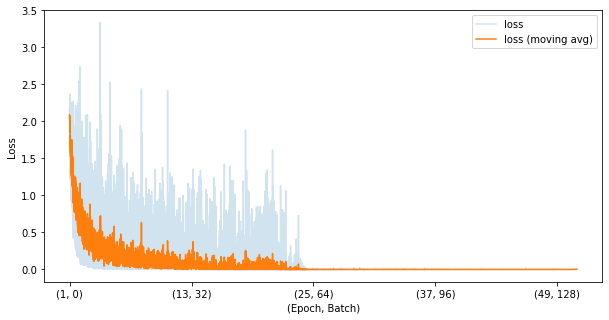

In [22]:
wandb.watch(net, criterion, log="all")
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

In [ ]:
torch.save(model, "")

In [ ]:
torch.save(model.state_dict(), filepath)

In [ ]:
model = torch.load("")

In [20]:
eval_dataset = ImagesDataset(x_eval2[0], y_eval2[0])
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

In [21]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()
# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"].to(device))
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.cpu().detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)

eval_predictions = eval_preds_df.idxmax(axis=1)
eval_true = y_eval2[0].idxmax(axis=1)
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy
# wandb.log({'Accuracy': accuracy})

100%|████████████████████████████████████████████████████████████████████████████████| 413/413 [00:54<00:00,  7.52it/s]


0.8853850818677986

In [22]:
print("True labels (training):")
y_train2[0].idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    1994
antelope_duiker     1979
civet_genet         1938
leopard             1803
blank               1771
rodent              1610
bird                1312
hog                  783
dtype: int64

In [23]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


blank               675
antelope_duiker     495
monkey_prosimian    455
civet_genet         449
leopard             407
rodent              348
bird                287
hog                 182
dtype: int64

In [24]:
print("True labels (eval):")
y_eval2[0].idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    498
antelope_duiker     495
civet_genet         485
leopard             451
blank               442
rodent              403
bird                329
hog                 195
dtype: int64

In [25]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ000000                bird
ZJ000001               blank
ZJ000002                bird
ZJ000003    monkey_prosimian
ZJ000004             leopard
dtype: object

In [26]:
eval_true = y_eval2[0].idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.15100060642813826

In [41]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy


0.8853850818677986

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval2[0].idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

## Test Submission

In [73]:
# Test submission
from torch.utils.data import DataLoader
test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
model = torch.load("")

preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        # run the forward step
        logits = model.forward(batch["image"].to(device))
        # apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.cpu().detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

submission_df = pd.concat(preds_collector)
submission_df

In [43]:
submission_format = pd.read_csv("submission_format.csv", index_col="id")
assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

In [44]:
submission_df.to_csv(".csv")

In [28]:
eval_pred_copy = final_df.copy()
counter = 0
for index, row in eval_pred_copy.iterrows():
    value = row.max()
    if value >= 0.6:
        pass
    else:
        elif value == row[4]: # 4 - hog 
            eval_pred_copy.iloc[counter][5] = eval_pred_copy.iloc[counter][5] + 0.05

        elif value == row[2]: # 2 - blank
            eval_pred_copy.iloc[counter][2] = eval_pred_copy.iloc[counter][2] + 0.2
        elif value == row[0]: # 0 - antelope
            eval_pred_copy.iloc[counter][0] = eval_pred_copy.iloc[counter][0] + 0.1
    counter = counter + 1

In [29]:
submission_format = pd.read_csv("submission_format.csv", index_col="id")

In [30]:
assert all(eval_pred_copy.index == submission_format.index)
assert all(eval_pred_copy.columns == submission_format.columns)

In [31]:
eval_pred_copy.to_csv(".csv")

## Ensemble

In [17]:
from torch.utils.data import DataLoader
test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
model1 = torch.load(".pth")
model2 = torch.load(".pth")
models = [model1,model2]
submissions = []
for i in models:
# put the model in eval mode so we don't update any parameters
    preds_collector = []
    if i == model1:
        print(0)
        val_transform = A.Compose([
            A.Resize(224, 224), 
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ToTensorV2(),
            ])
    else:
        print("else")
        val_transform = A.Compose([
            A.Resize(224, 224), 
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
            ])
        from torch.utils.data import DataLoader
        test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
        test_dataloader = DataLoader(test_dataset, batch_size=8)
    
    
    i.eval()

# we aren't updating our weights so no need to calculate gradients
    with torch.no_grad():
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            # run the forward step
            logits = i.forward(batch["image"].to(device))
            # apply softmax so that model outputs are in range [0,1]
            preds = nn.functional.softmax(logits, dim=1)
            # store this batch's predictions in df
            # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
            preds_df = pd.DataFrame(
                preds.cpu().detach().numpy(),
                index=batch["image_id"],
                columns=species_labels,
            )
            preds_collector.append(preds_df)

    submission_df = pd.concat(preds_collector)
    submissions.append(submission_df)

In [ ]:
df_combine = submissions[0] + submissions[1]
print(df_combine)
final_df = df_combine.divide(2)
print(final_df)

In [27]:
submission_format = pd.read_csv("submission_format.csv", index_col="id")
assert all(final_df.index == submission_format.index)
assert all(final_df.columns == submission_format.columns)
final_df.to_csv(".csv")

In [ ]:
df_combine = submissions[0] + vit_final
print(df_combine)
final_df = df_combine.divide(2)
print(final_df)

In [29]:
submission_format = pd.read_csv("submission_format.csv", index_col="id")
assert all(final_df.index == submission_format.index)
assert all(final_df.columns == submission_format.columns)
final_df.to_csv(".csv")

In [ ]:
model1 = torch.load(".pth")
model2 = torch.load(".pth")
model3 = torch.load(".pth")
model4 = torch.load(".pth")
model5 = torch.load(".pth")
models = [model1,model2,model3,model4,model5]
submissions = []
for i in models:
# put the model in eval mode so we don't update any parameters
    preds_collector = []
#     if i == model4:
#         print(0)
#         val_transform = A.Compose([
#             A.Resize(224, 224), 
#             A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#             ToTensorV2(),
#             ])
#         from torch.utils.data import DataLoader
#         test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
#         test_dataloader = DataLoader(test_dataset, batch_size=8)
#     elif i == model5:
#         print(1)
#         val_transform = A.Compose([
#             A.Resize(288, 288), 
#             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#             ToTensorV2(),
#             ])
#         from torch.utils.data import DataLoader
#         test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
#         test_dataloader = DataLoader(test_dataset, batch_size=8)
#     else:
#         print("else")
#         val_transform = A.Compose([
#             A.Resize(224, 224), 
#             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#             ToTensorV2(),
#             ])
#         from torch.utils.data import DataLoader
#         test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
#         test_dataloader = DataLoader(test_dataset, batch_size=8)
    
    
    i.eval()

# we aren't updating our weights so no need to calculate gradients
    with torch.no_grad():
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            # run the forward step
            logits = i.forward(batch["image"].to(device))
            # apply softmax so that model outputs are in range [0,1]
            preds = nn.functional.softmax(logits, dim=1)
            # store this batch's predictions in df
            # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
            preds_df = pd.DataFrame(
                preds.cpu().detach().numpy(),
                index=batch["image_id"],
                columns=species_labels,
            )
            preds_collector.append(preds_df)

    submission_df = pd.concat(preds_collector)
    submissions.append(submission_df)


In [ ]:
## kombinace 5 modelu ,ensemble
print(submissions[0])
print(submissions[1])
print(submissions[2])  
df_combine = submissions[0] + submissions[1] + submissions[2] + submissions[3] + submissions[4]
print(df_combine)
final_df = df_combine.divide(5)
print(final_df)

In [22]:
submission_format = pd.read_csv("submission_format.csv", index_col="id")
assert all(final_df.index == submission_format.index)
assert all(final_df.columns == submission_format.columns)
final_df.to_csv(".csv")

In [ ]:
vit_ensemble = pd.read_csv(".csv")

## Vykreslení špatně a správně klasifikovaných dat z val. množiny pro - Group_stratified

In [43]:
model = torch.load(".pth")

In [44]:
val_transform1 = A.Compose([
    A.Resize(224, 224),
    #A.Resize(256, 256),
    #A.CenterCrop(224,224), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
])

In [ ]:
from torch.utils.data import DataLoader
eval_dataset = ImagesDataset(x_eval1[4], y_eval1[4],transform = val_transform1)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)
eval_true = y_eval1[4].idxmax(axis=1)
preds_collector = []
# put the model in eval mode so we don't update any parameters
model.eval()
# we aren't updating our weights so no need to calculate gradients
valid_loss = 0.0
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"].to(device))
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.cpu().detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
competition_loss = log_loss(eval_true,eval_preds_df)
eval_predictions = eval_preds_df.idxmax(axis=1)
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
# validation_loss = valid_loss / len(eval_dataloader)
accuracy
print(competition_loss)

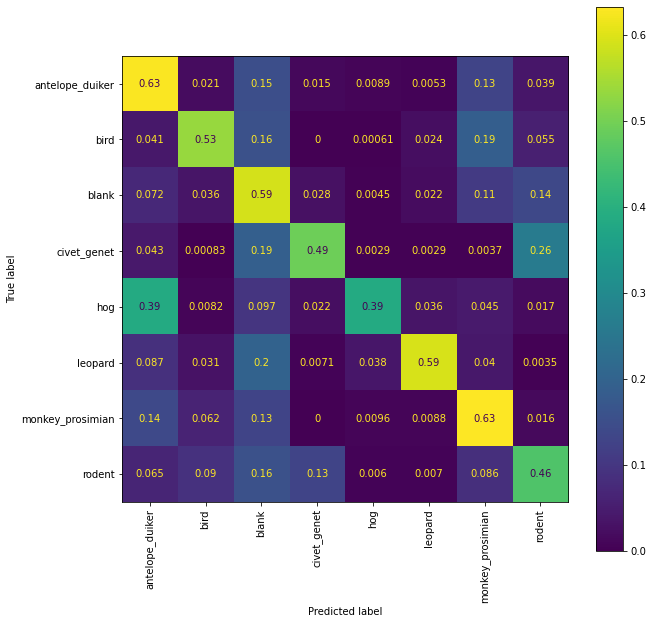

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    eval_tru.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    normalize = "pred",
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

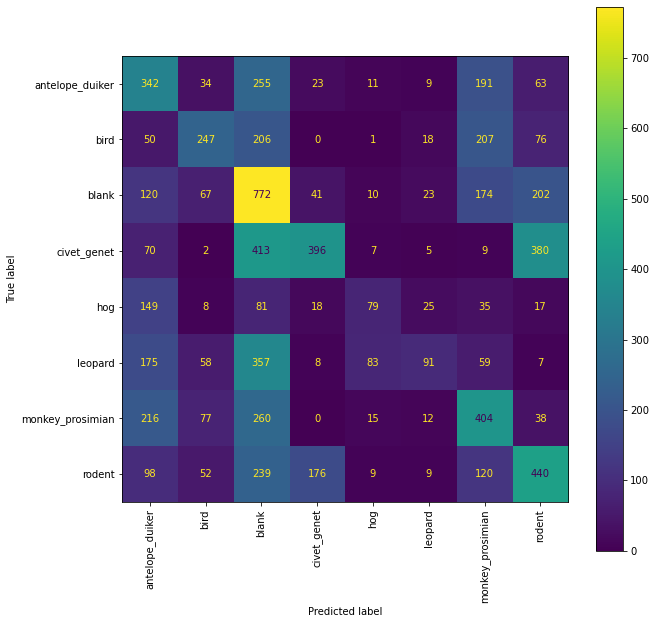

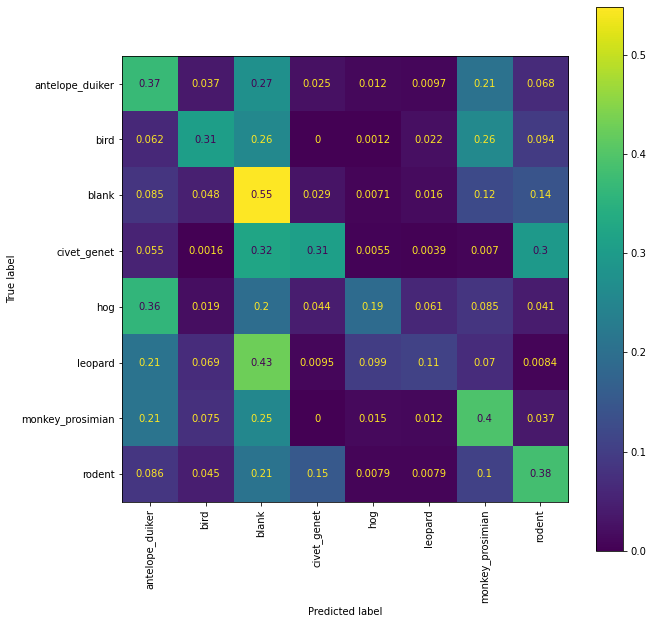

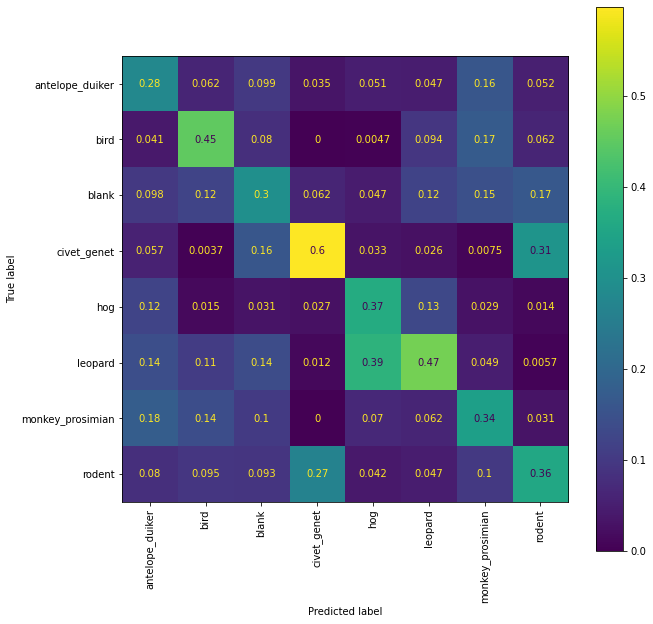

In [51]:
eval_pred_copy = eval_preds_df.copy()
y_eval_copy = eval_tru.copy()
for index, row in eval_preds_df.iterrows():
    value = row.max()
    if value >= 0.6:
        eval_pred_copy = eval_pred_copy.drop(index)
        y_eval_copy = y_eval_copy.drop(index)
        
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval_copy.idxmax(axis=1),
    eval_pred_copy.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval_copy.idxmax(axis=1),
    eval_pred_copy.idxmax(axis=1),
    normalize = "true", # 'pred'
    #normalize = "pred"
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval_copy.idxmax(axis=1),
    eval_pred_copy.idxmax(axis=1),
    normalize = "pred", # 'pred'
    #normalize = "pred"
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

In [ ]:
model1 = torch.load(".pth")
model2 = torch.load(".pth")
model3 = torch.load(".pth")
model4 = torch.load(".pth")
model5 = torch.load(".pth")
models = [model1] # ,model2,model3,model4,model5
evaluated = []
for i in models:
# put the model in eval mode so we don't update any parameters
    from torch.utils.data import DataLoader
    preds_collector = []
    if i == model1:
        print(0)
        val_transform1 = A.Compose([
            A.Resize(224, 224), 
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ToTensorV2(),
            ])
        eval_dataset = ImagesDataset(x_eval1[0], y_eval1[0],transform = val_transform1)
        eval_dataloader = DataLoader(eval_dataset, batch_size=8)
        eval_true = y_eval1[0].idxmax(axis=1)
#         from torch.utils.data import DataLoader
#         test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
#         test_dataloader = DataLoader(test_dataset, batch_size=8)
#     elif i == model2:
#         print(1)
#         val_transform1 = A.Compose([
#             A.Resize(224, 224), 
#             A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#             ToTensorV2(),
#             ])
#         eval_dataset = ImagesDataset(x_eval1[1], y_eval1[1],transform = val_transform1)
#         eval_dataloader = DataLoader(eval_dataset, batch_size=8)
#         eval_true = y_eval1[1].idxmax(axis=1)
#     elif i == model3:
#         print(2)
#         val_transform1 = A.Compose([
#             A.Resize(224, 224), 
#             A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#             ToTensorV2(),
#             ])
#         eval_dataset = ImagesDataset(x_eval1[2], y_eval1[2],transform = val_transform1)
#         eval_dataloader = DataLoader(eval_dataset, batch_size=8)
#         eval_true = y_eval1[2].idxmax(axis=1)
#     elif i == model4:
#         print(3)
#         val_transform1 = A.Compose([
#             A.Resize(224, 224), 
#             A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#             ToTensorV2(),
#             ])
#         eval_dataset = ImagesDataset(x_eval1[3], y_eval1[3],transform = val_transform1)
#         eval_dataloader = DataLoader(eval_dataset, batch_size=8)
#         eval_true = y_eval1[3].idxmax(axis=1)
#     else:
#         print(4)
#         val_transform1 = A.Compose([
#             A.Resize(224, 224), 
#             A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#             ToTensorV2(),
#             ])
#         eval_dataset = ImagesDataset(x_eval1[4], y_eval1[4],transform = val_transform1)
#         eval_dataloader = DataLoader(eval_dataset, batch_size=8)
#         eval_true = y_eval1[4].idxmax(axis=1)
#         from torch.utils.data import DataLoader
#         test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
#         test_dataloader = DataLoader(test_dataset, batch_size=8)
#     else:
#         print("else")
#         val_transform = A.Compose([
#             A.Resize(224, 224), 
#             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#             ToTensorV2(),
#             ])
#         from torch.utils.data import DataLoader
#         test_dataset = ImagesDataset(test_features.filepath.to_frame(),transform=val_transform)
#         test_dataloader = DataLoader(test_dataset, batch_size=8)
    
    
    i.eval()

# we aren't updating our weights so no need to calculate gradients
    
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
            # 1) run the forward step
            logits = model.forward(batch["image"].to(device))
            # 2) apply softmax so that model outputs are in range [0,1]
            preds = nn.functional.softmax(logits, dim=1)
            # 3) store this batch's predictions in df
            # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
            preds_df = pd.DataFrame(
                preds.cpu().detach().numpy(),
                index=batch["image_id"],
                columns=species_labels,
            )
            preds_collector.append(preds_df)
    eval_preds_df = pd.concat(preds_collector)
    evaluated.append(eval_preds_df)

In [ ]:
print(evaluated[0])
print(evaluated[1])
print(evaluated[2])  
df_combine = evaluated[0] + evaluated[1] + evaluated[2] + evaluated[3] + evaluated[4]
print(df_combine)
final_df = df_combine.divide(5)
print(final_df)

In [22]:
diff = eval_predictions == eval_true
a = x_eval1[0]["filepath"]
b = y_eval1[0].idxmax(axis=1)
cesty_spravne = []
cesty_spatne = []
jmeno_spravne = []
jmeno_spatne = []
counter = 0
for i in diff:
    if i == True:
        cesty_spravne.append(a[counter])
        jmeno_spravne.append(b[counter])
    else:
        cesty_spatne.append(a[counter])
        jmeno_spatne.append(b[counter])
    counter += 1

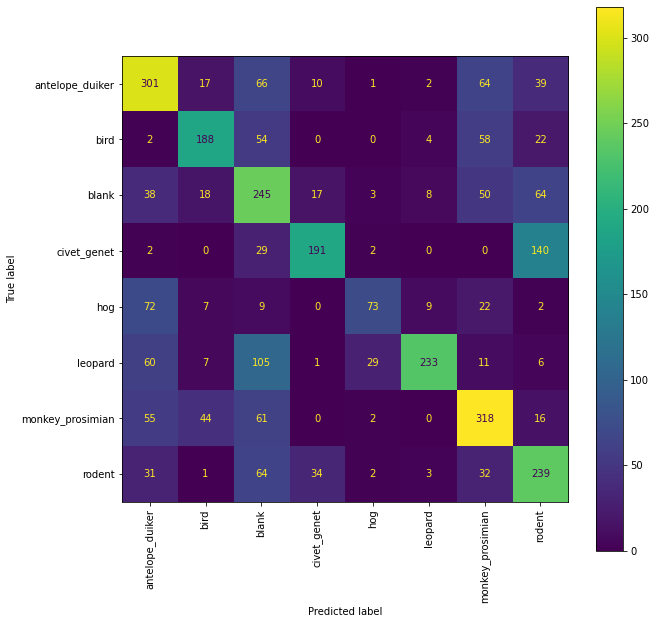

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval1[0].idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

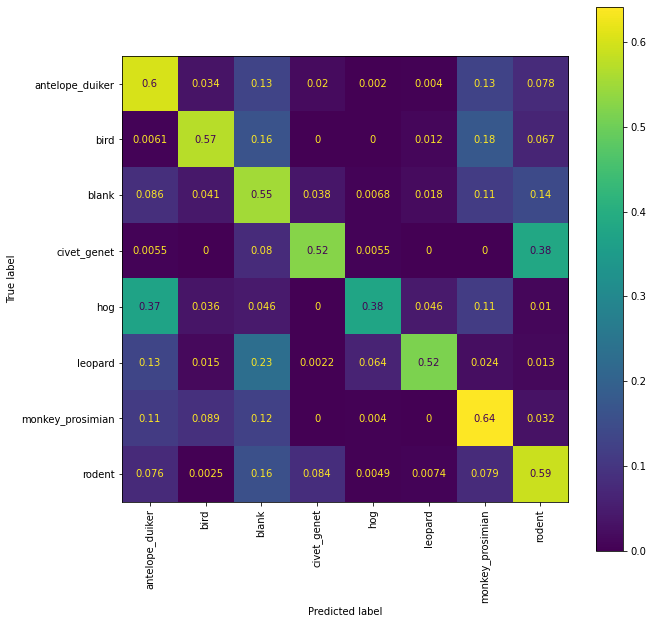

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval1[0].idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    normalize = "true",
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

In [25]:
a = (y_eval1[0].idxmax(axis=1) == "antelope_duiker").sum()
b =(y_eval1[0].idxmax(axis=1) == "bird").sum()
bl =(y_eval1[0].idxmax(axis=1) == "blank").sum()
c = (y_eval1[0].idxmax(axis=1) == "civet_genet").sum()
h = (y_eval1[0].idxmax(axis=1) == "hog").sum()
l = (y_eval1[0].idxmax(axis=1) == "leopard").sum()
m = (y_eval1[0].idxmax(axis=1) == "monkey_prosimian").sum()
r = (y_eval1[0].idxmax(axis=1) == "rodent").sum()

In [26]:
blank_list = (eval_preds_df.idxmax(axis=1) == "blank")

In [27]:
blank_second = []
blank_third = []
blank_second_value = []
blank_third_value = []
counter = 0
n = 3
proviz_list = []
for index, row in eval_preds_df.iterrows():
    if blank_list[counter] == True:
        for j in row.values:
            proviz_list.append(j)
        result = [proviz_list.index(i) for i in sorted(proviz_list, reverse=True)][:n]
        blank_second.append(result[1])
        blank_third.append(result[2])
        blank_second_value.append(proviz_list[result[1]])
        blank_third_value.append(proviz_list[result[2]])
        proviz_list = []
    counter = counter + 1
    

In [28]:
print(np.mean(blank_second_value))
print(np.mean(blank_third_value))
print(np.sqrt(np.var(blank_second_value)))
print(np.sqrt(np.var(blank_third_value)))

0.2175951
0.11842604
0.08073884
0.052772734


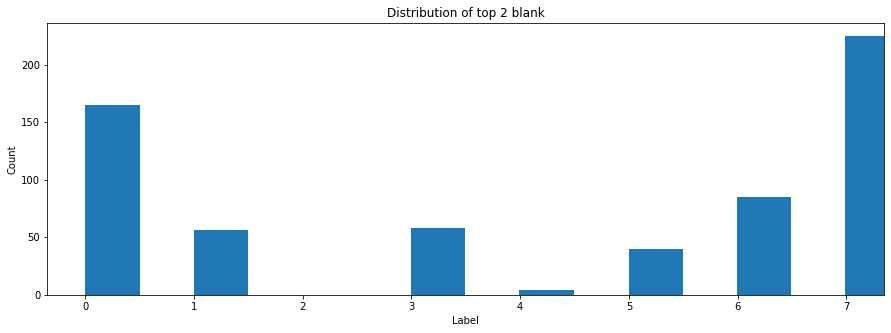

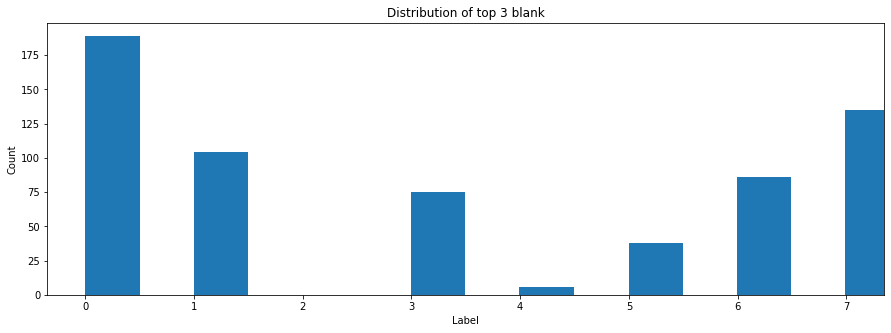

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [29]:
fig = plt.figure(figsize = (15,5))
plt.hist(blank_second , len(blank_second),width = 0.5)
plt.xlabel("Label" )
plt.ylabel("Count")
plt.title("Distribution of top 2 blank")
plt.show()
fig = plt.figure(figsize = (15,5))
plt.hist(blank_third , len(blank_third),width = 0.5)
plt.xlabel("Label" )
plt.ylabel("Count")
plt.title("Distribution of top 3 blank")
plt.show()
species_labels

## Civetky a hlodavci check

In [30]:
c = (y_eval1[0].idxmax(axis=1) == "civet_genet").sum()
civet_list = (eval_preds_df.idxmax(axis=1) == "civet_genet")

In [31]:
civet_second = []
civet_third = []
civet_second_value = []
civet_third_value = []
counter = 0
n = 3
proviz_list = []
for index, row in eval_preds_df.iterrows():
    if civet_list[counter] == True:
        for j in row.values:
            proviz_list.append(j)
        result = [proviz_list.index(i) for i in sorted(proviz_list, reverse=True)][:n]
        civet_second.append(result[1])
        civet_third.append(result[2])
        civet_second_value.append(proviz_list[result[1]])
        civet_third_value.append(proviz_list[result[2]])
        proviz_list = []
    counter = counter + 1

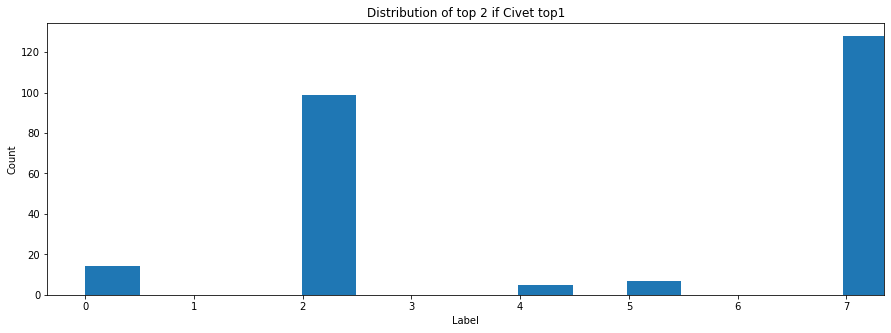

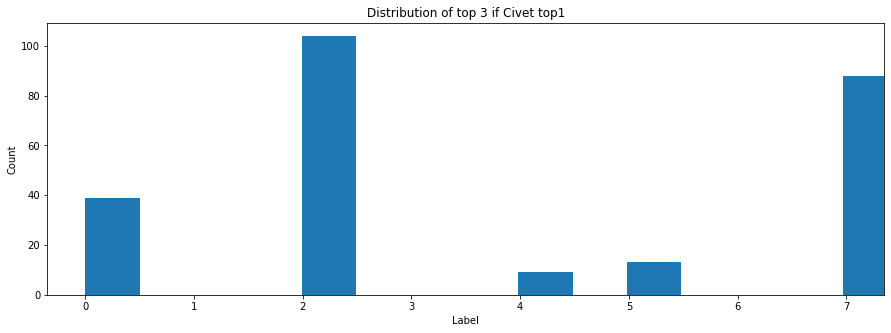

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [32]:
fig = plt.figure(figsize = (15,5))
plt.hist(civet_second , len(civet_second),width = 0.5)
plt.xlabel("Label" )
plt.ylabel("Count")
plt.title("Distribution of top 2 if Civet top1")
plt.show()
fig = plt.figure(figsize = (15,5))
plt.hist(civet_third , len(civet_third),width = 0.5)
plt.xlabel("Label" )
plt.ylabel("Count")
plt.title("Distribution of top 3 if Civet top1")
plt.show()
species_labels

In [33]:
r = (y_eval1[0].idxmax(axis=1) == "rodent").sum()
rodent_list = (eval_preds_df.idxmax(axis=1) == "rodent")

In [34]:
rodent_second = []
rodent_third = []
rodent_second_value = []
rodent_third_value = []
counter = 0
n = 3
proviz_list = []
for index, row in eval_preds_df.iterrows():
    if rodent_list[counter] == True:
        for j in row.values:
            proviz_list.append(j)
        result = [proviz_list.index(i) for i in sorted(proviz_list, reverse=True)][:n]
        rodent_second.append(result[1])
        rodent_third.append(result[2])
        rodent_second_value.append(proviz_list[result[1]])
        rodent_third_value.append(proviz_list[result[2]])
        proviz_list = []
    counter = counter + 1

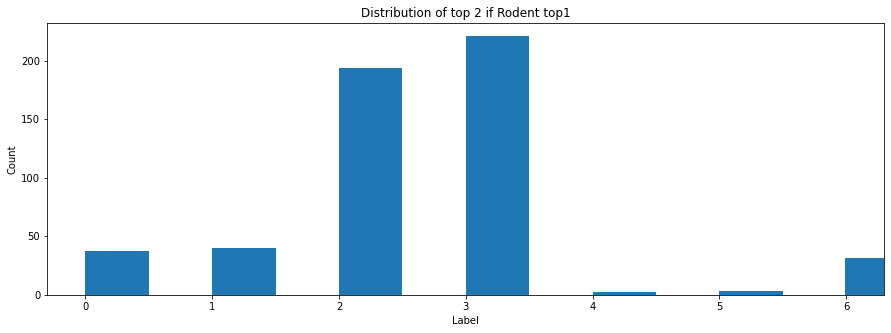

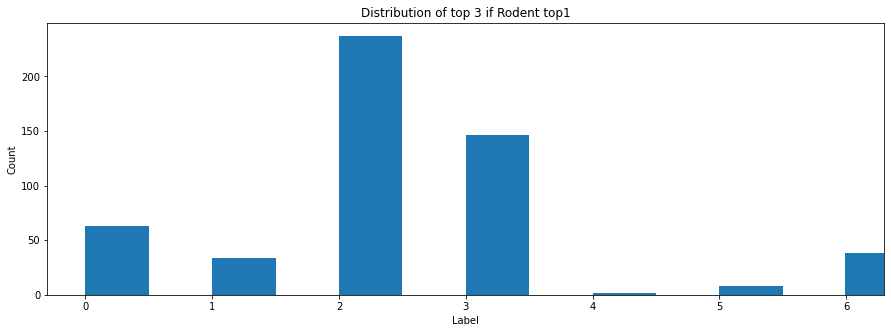

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [35]:
fig = plt.figure(figsize = (15,5))
plt.hist(rodent_second , len(rodent_second),width = 0.5)
plt.xlabel("Label" )
plt.ylabel("Count")
plt.title("Distribution of top 2 if Rodent top1")
plt.show()
fig = plt.figure(figsize = (15,5))
plt.hist(rodent_third , len(rodent_third),width = 0.5)
plt.xlabel("Label" )
plt.ylabel("Count")
plt.title("Distribution of top 3 if Rodent top1")
plt.show()
species_labels

In [54]:
eval_preds_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ000001,0.128779,0.037032,0.415092,0.006078,0.000703,0.008118,0.250467,0.153731
ZJ000015,0.215616,0.003272,0.536964,0.076910,0.028314,0.028431,0.007943,0.102551
ZJ000023,0.009223,0.000934,0.071661,0.049049,0.006179,0.847790,0.002345,0.012819
ZJ000035,0.010291,0.000325,0.164288,0.034784,0.054694,0.001213,0.000515,0.733890
ZJ000037,0.822364,0.033619,0.007718,0.001424,0.020013,0.002456,0.109730,0.002677
...,...,...,...,...,...,...,...,...
ZJ016471,0.042480,0.767561,0.025709,0.000919,0.001091,0.002135,0.126758,0.033347
ZJ016475,0.014176,0.065944,0.215572,0.012045,0.028036,0.558798,0.074010,0.031420
ZJ016476,0.005948,0.000168,0.181647,0.379482,0.003161,0.001566,0.000199,0.427829
ZJ016478,0.010504,0.000307,0.253015,0.064126,0.054880,0.002898,0.000361,0.613909


In [36]:
nazev_obrazku_spravne = []
nazev_obrazku_spatne = []
hodnoty_obrazku_spravne = []
hodnoty_obrazku_spatne = []
counter = 0
counter1 = 0
for i in cesty_spatne:
    obrazek = i[15:23]
    nazev_obrazku_spatne.append(obrazek)
for i in cesty_spravne:
    obrazek = i[15:23]
    nazev_obrazku_spravne.append(obrazek)
for index, row in eval_preds_df.iterrows():
    value = row.max()
    if counter < len(nazev_obrazku_spravne):
        if index == nazev_obrazku_spravne[counter]:
            hodnoty_obrazku_spravne.append(value)
            counter = counter + 1
    if counter1 < len(nazev_obrazku_spatne):
        if index == nazev_obrazku_spatne[counter1]:
            hodnoty_obrazku_spatne.append(value)
            counter1 = counter1 + 1
mean_spatne = np.mean(hodnoty_obrazku_spatne)
mean_spravne = np.mean(hodnoty_obrazku_spravne)
var_spatne = np.var(hodnoty_obrazku_spatne)
var_spravne = np.var(hodnoty_obrazku_spravne)
smer_odch_spatne = np.sqrt(var_spatne)
smer_odch_spravne = np.sqrt(var_spravne)
print(mean_spatne)
print(mean_spravne)
print(smer_odch_spatne)
print(smer_odch_spravne)

0.5254006334423592
0.7176881142260644
0.16641916124456135
0.211291740049108


In [31]:
# import shutil 
# import os 
# for f in cesty_spatne:
#     shutil.copy(f, 'val_wrong')

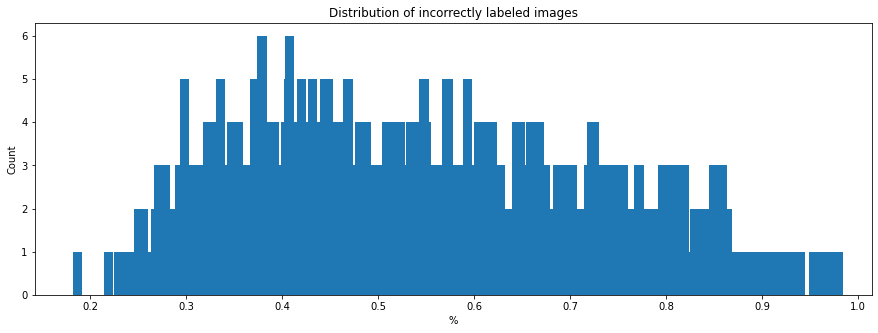

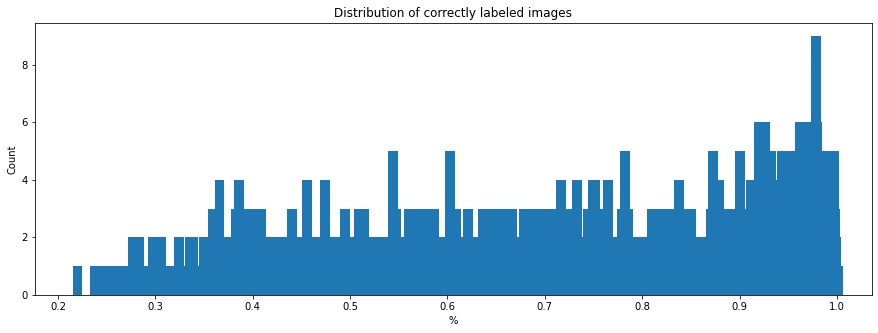

In [37]:
fig = plt.figure(figsize = (15,5))
plt.hist(hodnoty_obrazku_spatne , len(hodnoty_obrazku_spatne),width = 0.01)
plt.xlabel("%" )
plt.ylabel("Count")
plt.title("Distribution of incorrectly labeled images")
plt.show()
fig2 = plt.figure(figsize = (15,5))
plt.hist(hodnoty_obrazku_spravne , len(hodnoty_obrazku_spravne),width = 0.01)
plt.xlabel("%" )
plt.ylabel("Count")
plt.title("Distribution of correctly labeled images")
plt.show()

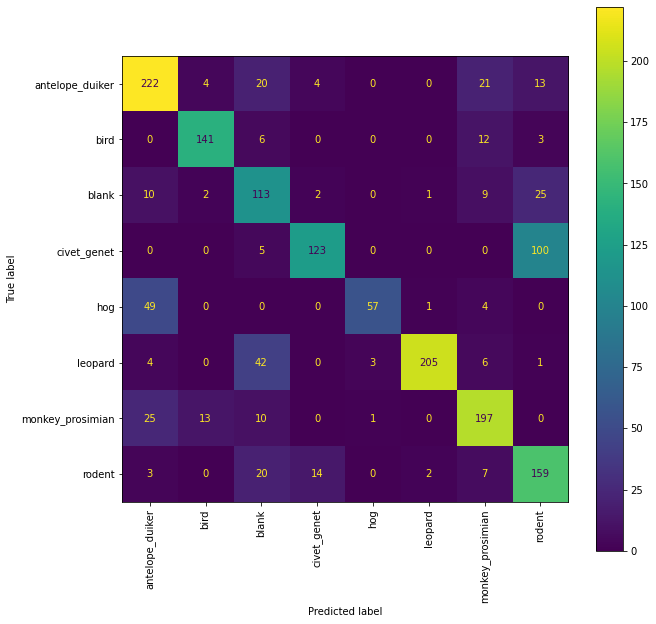

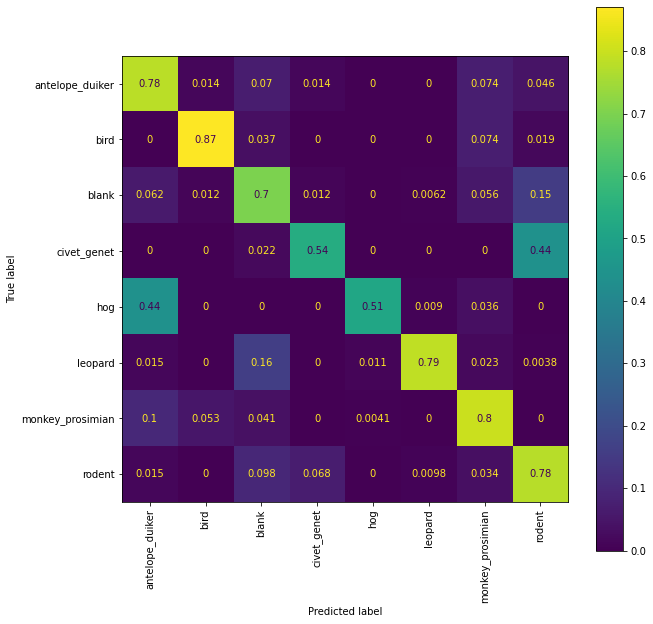

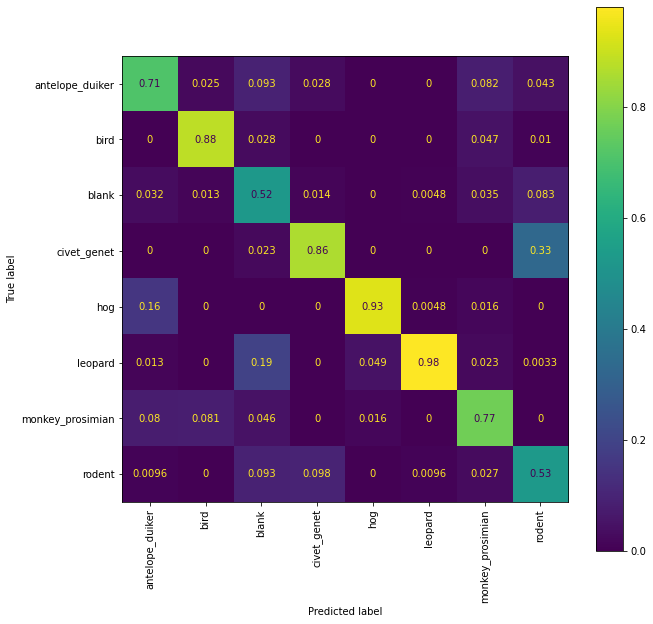

In [39]:
eval_pred_copy = eval_preds_df.copy()
y_eval_copy = y_eval1[0].copy()
for index, row in eval_preds_df.iterrows():
    value = row.max()
    if value <= 0.6:
        eval_pred_copy = eval_pred_copy.drop(index)
        y_eval_copy = y_eval_copy.drop(index)
        
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval_copy.idxmax(axis=1),
    eval_pred_copy.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval_copy.idxmax(axis=1),
    eval_pred_copy.idxmax(axis=1),
    normalize = "true", # 'pred'
    #normalize = "pred"
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval_copy.idxmax(axis=1),
    eval_pred_copy.idxmax(axis=1),
    normalize = "pred", # 'pred'
    #normalize = "pred"
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)


## Vizualizace augmentation dat
 A.HorizontalFlip(p=0.5),
 A.GaussianBlur(blur_limit=3 ,p=0.5),
 A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
 A.RandomBrightness(p=1)
 A.RGBShift(p=1)
 A.RandomContrast(limit = 0.5,p = 1),
 A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]
 A.Equalize (mode='pil', by_channels=True, mask=None, mask_params=(), always_apply=False, p=0.5)

In [ ]:
import matplotlib.image as mpimg
import random
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0, len(cesty_spravne)), 20)
# for i in randomlist:
#     fig = plt.figure()
#     ax = fig.add_subplot(2, 2, 2)
#     img =  mpimg.imread(cesty_spravne[i])
#     imgplot = plt.imshow(img)
#     ax.set_title(f"{cesty_spravne[i][15:23]} | {jmeno_spravne[i]}")
    
    
# fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
# for number, ax in zip(randomlist, axes.flat):
#     img =  mpimg.imread(cesty_spravne[number])
#     # plot etc
#     ax.imshow(img)
#     ax.set_title(f"{cesty_spravne[number][15:23]} | {jmeno_spravne[number]}")
    

fig1, axes1 = plt.subplots(nrows=10, ncols=2, figsize=(20, 40))
for number1, ax1 in zip(randomlist, axes1.flat):
    img =  mpimg.imread(cesty_spatne[number1])
    # plot etc
    ax1.imshow(img)
    ax1.set_title(f"{cesty_spatne[number1][15:23]} | {jmeno_spatne[number1]}")

In [ ]:
obrazky = [50]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2,figsize=(20, 30))
chosen_img =  mpimg.imread(cesty_spatne[50])
ax1.imshow(chosen_img)
ax1.set_title(f"Normal")
augmented_image = transform_flip(image=chosen_img)['image']
ax2.imshow(augmented_image)
ax2.set_title(f"Flip")
augmented_image = transform_blur(image=chosen_img)['image']
ax3.imshow(augmented_image)
ax3.set_title(f"Blur")
augmented_image = transform_jitter(image=chosen_img)['image']
ax4.imshow(augmented_image)
ax4.set_title(f"Jitter")
augmented_image = transform_bright_con(image=chosen_img)['image']
ax5.imshow(augmented_image)
ax5.set_title(f"Bright_Con")
augmented_image = transform_shift(image=chosen_img)['image']
ax6.imshow(augmented_image)
ax6.set_title(f"Shift")
augmented_image = transform_hsv(image=chosen_img)['image']
ax7.imshow(augmented_image)
ax7.set_title(f"HSV")
augmented_image = transform_equ(image=chosen_img)['image']
ax8.imshow(augmented_image)
ax8.set_title(f"Equ")

In [38]:
train_transform1 = A.Compose([
    
    A.Resize(256, 256),
    A.CenterCrop(224,224),
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
])

transform_flip = A.Compose([
    A.HorizontalFlip(p=1),
])
transform_blur = A.Compose([
    A.GaussianBlur(blur_limit = (3,7) ,p=1),
])
transform_jitter = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1),
])
transform_bright_con = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,p=1),
])
transform_shift = A.Compose([
    A.RGBShift(p=1),
])
transform_hsv = A.Compose([
    A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
])
transform_equ = A.Compose([
    A.Equalize (mode='pil', by_channels=True, mask=None, mask_params=(), always_apply=False, p=1),
])



In [23]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussianBlur(blur_limit = (3,7) ,p=0.2),
    A.OneOf([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,p=1),
        ], p=0.5),
    A.OneOf([
            A.HueSaturationValue(p=0.6,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
            A.RGBShift(p=0.4),
        ], p=0.2),
    A.Equalize (mode='pil', by_channels=True, mask=None, mask_params=(), always_apply=False, p=0.05),
#     A.Resize(224, 224), 
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
])